In [9]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from utils import *
from scipy.optimize import lsq_linear
from ian.dset_utils import *
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize']  = (6.0, 4.0)
plt.rcParams['figure.dpi'] = 72.0
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
def getPermutedTensor(factors, lambdas, tensorX, NDIRS):
    
    """Find the optimal circular-shifts used by the permuted decomposition to produce
    the tensor components, and apply it to the original tensor."""
    
    # Compute reconstructed tensor by scaling the first mode by the lambdas and 
    # multiplying by the kathri rao product of the other modes
    fittensor = np.reshape((lambdas * factors[0]) @ khatri_rao(factors[1:]).T, tensorX.shape)

    if NDIRS == 1: #no shifting possible, so simply return original tensor
        return tensorX, fittensor

    N = tensorX.shape[0]
    NSTIMS = tensorX.shape[1]
    RLEN = tensorX.shape[2]

    shape4d = (N,NSTIMS,NDIRS,RLEN//NDIRS)
    shapeDot = (N,RLEN)
    tensor4d = np.reshape(tensorX,shape4d,order='F')

    objs = np.empty((NSTIMS,N,NDIRS))
    obj_shifts = np.empty((NSTIMS,N))
    #find best shift (argmin) per stim for all cells at once
    for si in range(NSTIMS):
        for shifti in range(NDIRS):
            # cf. matlab code in `permuted-decomposition/matlab/my_tt_cp_fg.m`
            objs[si,:,shifti] = -np.sum(fittensor[:,si,:] * np.reshape(np.roll(tensor4d[:,si],shifti,1),shapeDot,order='F'), 1)
        obj_shifts[si] = np.argmin(objs[si],axis=1)

    #apply shifts
    shifted_tensor = np.zeros_like(tensorX)
    for shifti in range(NDIRS):
        rolledX = np.reshape(np.roll(tensor4d,shifti,2), tensorX.shape, order='F')
        for si in range(NSTIMS):
            shifted_tensor[(obj_shifts[si] == shifti),si,:] = rolledX[(obj_shifts[si] == shifti),si,:]

    #check that we get the same fit -- OK
    # normsqX = np.square(norm(tensorX.ravel()))
    # print((np.square(norm(shifted_tensor.ravel() - fittensor.ravel())))/( normsqX))
    # print('rec. error',preComputed[best_nfactors]['all_objs'][best_rep])
    return shifted_tensor, fittensor

def getNeuralMatrix(scld_permT, factors, lambdas, NDIRS, all_zeroed_stims=None,
                    order='F', verbose=True):
    """Computes the final neural matrix, X, by fitting the permuted tensor scaled by
    relative stimulus magnitudes using the factors obtained from NTF.
    
    Any previously zeroed out responses are now also permuted by the circular-shift
    producing the best fit.
    
    Additionally, a rebalancing of the factor magnitudes is applied to attribute
    a meaningful interpretation to the final coefficients.
    
    -------------------
    Arguments:
    
    scld_permT: ndarray, permuted tensor scaled by relative stimulus FRs
    
    factors: list, [neural_factors, stimulus_factors, response_factors] (normalized)
    
    lambdas: ndarray, shape (R,), where R is the number of components being used
    
    NDIRS: int, number of stimulus directions (rows in original 2D response maps)
    
    all_zeroed_stims: dict, {cell: (tuple of zeroed stim idxs)}, default None
    
    order: str, order used to flatten the original 2D response maps, default 'F' 
    
    -------------------
    Returns:
    X: ndarray, shape (Ncells, R), neural encoding matrix
    
    new_scld_permT: ndarray, tensor including previously zeroed out responses (if any)
    
    """

    R = lambdas.size
    
    #rebalance factor loadings based on relative stimulus contributions + scale by lambdas
    stim_factors = factors[1].copy()
    stim_scls = stim_factors.max(0,keepdims=1)
    stim_factors /= stim_scls

    neural_factors = factors[0].copy()
    neural_factors *= lambdas * stim_scls
    
    # rescaled stim x response coords
    new_coords = np.stack([khatri_rao([stim_factors[:,r][:,None],factors[2][:,r][:,None]]).ravel() for r in range(R)],axis=1)

    
    Ncells = scld_permT.shape[0]
    NSTIMS = scld_permT.shape[1]
    
    X = np.zeros((Ncells,R))
    
    new_scld_permT = scld_permT.copy()

    for c in range(Ncells):
        
        if verbose and (c+1) % 50 == 0: print(c+1,end=' ')

        if all_zeroed_stims is not None and c in all_zeroed_stims:
            # Any previously zeroed out responses are now also permuted by the circular-shift
            # producing the best fit.
            
            lowest_cost = np.inf
            #for each shift of all zeroed-stims together
            for shifti in range(NDIRS):
                shifted_cell_data = scld_permT[c].copy()

                for si in all_zeroed_stims[c]:
                    #rotate orig_data
                    si_2d = shifted_cell_data[si].reshape((NDIRS,-1),order=order)
                    shifted_cell_data[si] = np.roll(si_2d,shifti,axis=0).ravel(order=order)

                #compute fit cost
                res = lsq_linear(new_coords,shifted_cell_data.ravel(),bounds=(0,np.inf))
                coeffs, cost = res['x'], res['cost']

                #if lower reconstruction cost, update best shift combo
                if cost < lowest_cost:
                    lowest_cost = cost
                    best_shift = shifti
                    best_coeffs = coeffs
                    best_partial = True
                    new_scld_permT[c] = shifted_cell_data

            new_coeffs = best_coeffs

                
        else:#if no zeroed stims
            # update coefficients to fit our stimulus-rescaled tensor
            new_coeffs = lsq_linear(new_coords,scld_permT[c].ravel(),bounds=(0,np.inf))['x']

        # sqrt so that, for each stimulus, the magnitude of a vector of coeffs for factors
        # representing that stimulus can be equal to 1, even if that stimulus response 
        # is split across multiple factors. This ultimately leads to better distances
        # between neurons
        X[c] = np.sqrt(new_coeffs)

    return X, new_scld_permT

### load DG

In [2]:
mytensorname = 'drifting_gratings_VISp_shiftdirs_p0.001_32xp_N1261'
AREA = mytensorname.split('_shiftdirs')[0].split('_')[-1]
print(AREA)

datadir = 'tensor-data'

NDIRS = 8 #number of stimulus directions (rows in original 2-D response maps)

# Load precomputed tensor and aux files (see `creating-the-tensor/creating-the-tensor.ipynb`)

sigT = np.load(f'{datadir}/{mytensorname}_sigT.npy')
allT = np.load(f'{datadir}/{mytensorname}_allT.npy')
with open(f'{datadir}/{mytensorname}_all_zeroed_stims.pkl','rb') as f:
    all_zeroed_stims = pickle.load(f)
cell_maxFRs_DG = np.load(f'{datadir}/{mytensorname}_cell_maxFRs.npy')

N = sigT.shape[0]
NSTIMS = sigT.shape[1]
RLEN = sigT.shape[2]

# Compute relative FRs between stimuli for each cell
relFRs_DG = np.array([cell_maxFRs_DG[c]/cell_maxFRs_DG[c].max() for c in range(len(cell_maxFRs_DG))])

# Load metrics (precomputed by the Allen) for these neurons (see build_tensor-dg.iypnb)
with open(f'{datadir}/{mytensorname}_metrics_df.pkl','rb') as f:
    metrics_df = pickle.load(f)

VISp


In [4]:
R = 11

best_factors_dg = np.load(f'{datadir}/{mytensorname}_R{R}_factors.npy',allow_pickle=True)
best_lambdas_dg = np.load(f'{datadir}/{mytensorname}_R{R}_lambdas.npy',allow_pickle=True)

# remove any eventual zero-norm factor
posnorms = ~np.isclose(best_lambdas_dg,0)
lambdas = best_lambdas_dg[posnorms]
# make sure they are all normalized
factors = [f[:,posnorms]/np.linalg.norm(f[:,posnorms],axis=0,keepdims=1) for f in best_factors_dg]

# find the permuted version of sigT that gave rise to the factors -- this is
# necessary for computing the actual rec error
permT, fitT = getPermutedTensor(factors, lambdas, sigT, NDIRS)


#now, add non-signif stims
#note: these haven't been shifted by our factorization -- will address that later
for c, zeroed_stims in all_zeroed_stims.items():
    for si in zeroed_stims:
        permT[c,si] = allT[c,si]
        
#finally, scale the (unit-normed) stimuli by their relative FRs
scld_permT = permT * relFRs_DG[...,None]

# we will now proceed to adjust the neural loadings to reflect this, and to include the non-signif responses

X_dg, all_scld_permT_dg = getNeuralMatrix(
    scld_permT, factors, lambdas, NDIRS, all_zeroed_stims, order='F', verbose=True)

50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 

### load SG

In [5]:
mytensorname_SG = 'static_gratings_VISp_shiftdirs_p0.001_32xp_N1261'
AREA = mytensorname_SG.split('_shiftdirs')[0].split('_')[-1]
print(AREA)

datadir = 'tensor-data'

NDIRS_SG = 6 #number of stimulus directions (rows in original 2-D response maps)

# Load precomputed tensor and aux files (see `creating-the-tensor/creating-the-tensor.ipynb`)

sigT = np.load(f'{datadir}/{mytensorname_SG}_sigT.npy')
allT = np.load(f'{datadir}/{mytensorname_SG}_allT.npy')
with open(f'{datadir}/{mytensorname_SG}_all_zeroed_stims.pkl','rb') as f:
    all_zeroed_stims = pickle.load(f)
cell_maxFRs_SG = np.load(f'{datadir}/{mytensorname_SG}_cell_maxFRs.npy')

N = sigT.shape[0]
NSTIMS_SG = sigT.shape[1]
RLEN_SG = sigT.shape[2]

# Compute relative FRs between stimuli for each cell
relFRs_SG = np.array([cell_maxFRs_SG[c]/cell_maxFRs_SG[c].max() for c in range(len(cell_maxFRs_SG))])

VISp


In [7]:
R = 14

best_factors_sg = np.load(f'{datadir}/{mytensorname_SG}_R{R}_factors.npy',allow_pickle=True)
best_lambdas_sg = np.load(f'{datadir}/{mytensorname_SG}_R{R}_lambdas.npy',allow_pickle=True)

# remove any eventual zero-norm factor
posnorms = ~np.isclose(best_lambdas_sg,0)
lambdas = best_lambdas_sg[posnorms]
# make sure they are all normalized
factors = [f[:,posnorms]/np.linalg.norm(f[:,posnorms],axis=0,keepdims=1) for f in best_factors_sg]

# find the permuted version of sigT that gave rise to the factors -- this is
# necessary for computing the actual rec error
permT, fitT = getPermutedTensor(factors, lambdas, sigT, NDIRS_SG)


#now, add non-signif stims
#note: these haven't been shifted by our factorization -- will address that later
for c, zeroed_stims in all_zeroed_stims.items():
    for si in zeroed_stims:
        permT[c,si] = allT[c,si]
        
#finally, scale the (unit-normed) stimuli by their relative FRs
scld_permT = permT * relFRs_SG[...,None]

# we will now proceed to adjust the neural loadings to reflect this, and to include the non-signif responses

X_sg, all_scld_permT_sg = getNeuralMatrix(
    scld_permT, factors, lambdas, NDIRS_SG, all_zeroed_stims, order='F', verbose=True)

50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 

### combine DG+SG

In [12]:
X = np.concatenate([X_dg, X_sg], axis=1)
X.shape

(1261, 25)

nPCs=10


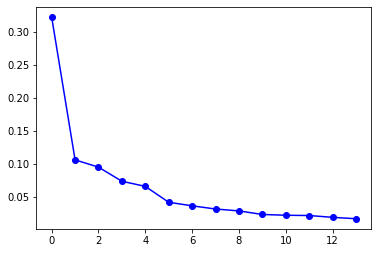

In [13]:
# finally, eliminate possible redundancy among factors in the neural matrix using PCA

MIN_EXPL_VAR_RATIO = 0.8

pca = PCA(len(lambdas))
pcaX = pca.fit_transform(X)

# number of PCs can be chosen based on a prespecified explained variance ratio,
nPCs = np.flatnonzero(np.cumsum(pca.explained_variance_ratio_) > MIN_EXPL_VAR_RATIO)[0] + 1
print(f'{nPCs=}')
# or simply by inspection of the variance spectrum
plt.plot(pca.explained_variance_ratio_, 'bo-')

newX = pcaX[:,:nPCs]

In [14]:
from ian.ian import * #https://github.com/dyballa/IAN/
from ian.embed_utils import *
from ian.dset_utils import *
from ian.utils import *
# compute matrix of squared distances
D2 = pwdists(newX, sqdists=True)

### Iteration 1 done. (0.14 s) - pruned 1 edge(s)
### Iteration 2 done. (0.03 s) - pruned 1 edge(s)
### Iteration 3 done. (0.03 s) - pruned 1 edge(s)
### Iteration 4 done. (0.03 s) - pruned 1 edge(s)
### Iteration 5 done. (0.03 s) - pruned 1 edge(s)
CONVERGED: no change in unweighted graph.
Total # edges pruned: 5, (0 disconnected points)
C-tuning weighted graph...
Unweighted graph stats: mean=1.082, median=0.995
Weighted graph stats: mean=1.069, median=1.011


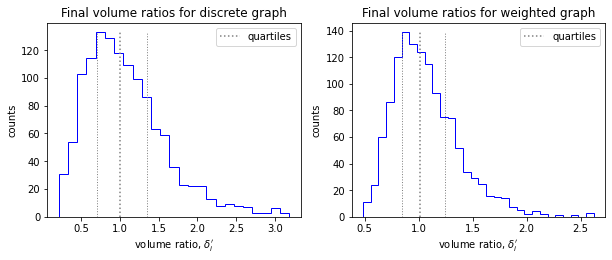

In [14]:
G, wG, optScales, disc_pts = IAN('exact-precomputed-sq', D2, obj='greedy')

In [ ]:
sp.sparse.save_npz(f'output-figs/{AREA}-wG',wG)
sp.sparse.save_npz(f'output-figs/{AREA}-G',G)

In [20]:
# Compute diffusion map embedding using the IAN weighted graph as similarity matrix

n_components = 6 #here choosing the first 3 components b/c these will be plotted. can pick more to look at higher-order coords
alpha = 1 #0=classical normalized Laplacian; 1=Laplace-Beltrami approximation


outliers = []
nonoutliers = [i for i in range(X.shape[0]) if i not in outliers]

diffmap_y, diffmap_evals = diffusionMapFromK(wG[nondel][:,nondel], n_components, alpha)

<AxesSubplot:xlabel='x', ylabel='y'>

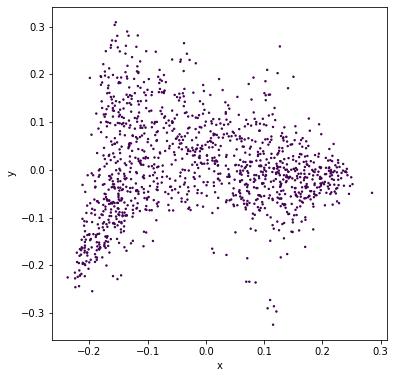

In [21]:
f, ax = subps(1,1,6,6) #create a 3-d subplot
c = None
plot2dScatter(diffmap_y[:,[0,3]], c, f_ax=(f,ax),s=2, axisEqual=False, noTicks=0)


In [ ]:
np.save(f'output-figs/{AREA}-manifold.npy',diffmap_y)